In [2]:
import tensorflow as tf
import segmentation_models as sm
import cv2
BACKBONE = 'resnet34'
IMG_HEIGHT = 256
IMG_WIDTH  = 256
IMG_CHANNELS =3
n_classes=3
import numpy as np

Segmentation Models: using `keras` framework.


In [2]:
def create_model():
    model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
    model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])
    return model

In [9]:
model=create_model()

In [72]:
from keras.models import load_model
model=load_model(r'landcover_25_epochs_RESNET_backbone_batch16.hdf5',compile=False)

In [16]:
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfl_classifier = converter.convert()


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmprcso29wu\assets


INFO:tensorflow:Assets written to: C:\Users\hp\AppData\Local\Temp\tmprcso29wu\assets


In [25]:
with open('classifier.tflite', 'wb') as f:
    f.write(tfl_classifier)

(1, 256, 256, 3)
(256, 256, 3) i


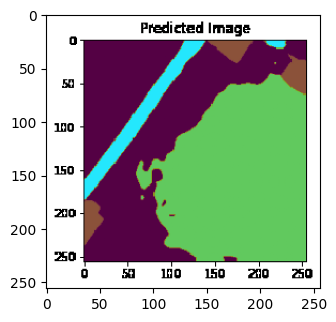

In [90]:
interpreter = tf.lite.Interpreter(model_path="classifier.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
img = load_image(r'C:\Users\hp\Downloads\test_image_output.png')
print(img.shape,'i')
interpreter.set_tensor(input_details[0]['index'], [img])
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

In [91]:
pred = np.argmax(output_data, axis=3)
pred.shape

(1, 256, 256)

numpy.ndarray

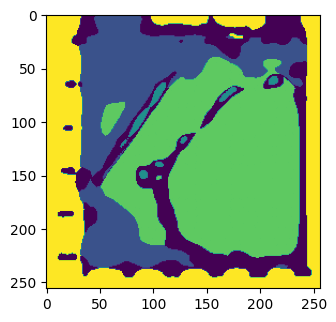

In [92]:
plt.figure(figsize=(12, 12))
plt.title('Testing Image')
plt.subplot(232)
plt.imshow(pred[0])
type(pred[0])

(1, 256, 256, 3)


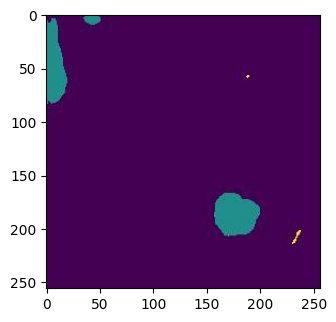

In [95]:

img = load_image(r'D:/t/hi.jpg')


In [6]:
import fiona
import numpy as np
from pathlib import Path

In [80]:
import cv2
img=cv2.imread(r'D:/a212/'+'boundary.jpg',1)
edges=cv2.Canny(img,100,200)
lines=cv2.HoughLinesP(image=edges,lines=np.array([]),rho=1,theta=np.pi/180,threshold=2,minLineLength=0,maxLineGap=0)
i=0;
for points in lines:
    list=[]
    k=[]
    k.append(points[0][0])
    k.append(points[0][1])
    a=tuple(k)
    list.append(a)
    k=[]
    k.append(points[0][2])
    k.append(points[0][3])
    a=tuple(k)
    list.append(a)
    schema = {
    'geometry':'LineString',
    'properties':[('Name','int')]
}
    mode='a'
    shpFile=Path(r'D:/a212/'+'shpFile.shp')
    if(shpFile.is_file()==False):
        mode='w'
    lineShp = fiona.open(r'D:/a212/'+'shpFile.shp',mode= mode,crs='EPSG:4326',driver='ESRI Shapefile', schema=schema)
    rowName='line'+str(i)
    i+=1
    rowDict = {
'geometry' : {'type':'LineString',
                 'coordinates': list},
        'id':i,
'properties': {'Name' : rowName},
}
    lineShp.write(rowDict)
    lineShp.close()

In [4]:
from tensorflow.keras.utils import load_img, img_to_array

from matplotlib import pyplot as plt
def load_image(img_path, show=True):

    img = load_img(img_path, target_size=(256, 256))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    #img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.figure(figsize=(12, 12))
        plt.title('Testing Image')
        plt.subplot(232)
        img_tensor1 = np.expand_dims(img_tensor, axis=0)
        plt.imshow(img_tensor1[0])  
        print(img_tensor1.shape)

    return img_tensor


In [23]:

from keras.utils import to_categorical
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
   # print("num_class=",num_class,mask)
    mask = to_categorical(mask, num_class)
    
    return (img,mask)


In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)



In [4]:
seed=24

batch_size= 16
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()


In [28]:
train_img_path = r'C:\Users\hp\Downloads\landData\data_for_keras_aug\train_images/'
train_mask_path = r"C:\Users\hp\Downloads\landData\data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=5)


val_img_path = r"C:\Users\hp\Downloads\landData\data_for_keras_aug/val_images/"
val_mask_path = r"C:\Users\hp\Downloads\landData\data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=5)

x, y = train_img_gen.__next__()


Found 16443 images belonging to 1 classes.
Found 16443 images belonging to 1 classes.


In [29]:

 = x.shape[3]

n_classes=5
print(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

256 256 3


# TFLITE 


In [77]:

import fiona
import os
import cv2
import numpy as np

import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random

from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

import geopandas as gpd
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import shape
import point
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import warnings; warnings.filterwarnings(action='ignore')
from matplotlib import pyplot as plt
%matplotlib inline
from pathlib import Path




(1, 256, 256, 3)


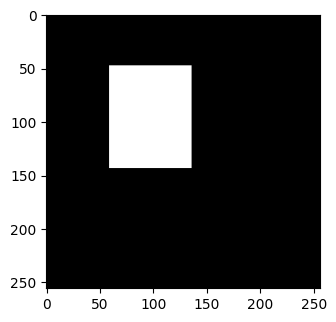

In [102]:
interpreter=tf.lite.Interpreter('classifier.tflite')
interpreter.allocate_tensors()
input_details=interpreter.get_input_details()
output_details=interpreter.get_output_details()
img=load_image(r'C:\Users\hp\Downloads\test.png')
interpreter.set_tensor(input_details[0]['index'],[img])
interpreter.invoke()
output_data=interpreter.get_tensor(output_details[0]['index'])
pred = np.argmax(output_data, axis=3)
output=pred[0]
h_flip = cv2.flip(pred[0], 0)
plt.imsave('boundary.jpg',h_flip)
img=cv2.imread('boundary.jpg',1)
edges=cv2.Canny(img,100,200)

plt.imsave('edges.jpg',edges)
lines=cv2.HoughLinesP(image=edges,lines=np.array([]),rho=1,theta=np.pi/180,threshold=2,minLineLength=0,maxLineGap=0)

In [103]:
len(lines)

153

In [104]:
import math
class Point:
    x=0
    y=0
    def __init__(self,x,y):
        self.x=x;
        self.y=y;
    def equal(self,p2):
        if self.x==p2.x and self.y==p2.y:
            return True;
        return False
    
    def dist(self,p2):
        t=math.sqrt(pow(p2.x-self.x,2)+pow(p2.y-self.y,2))
        return t

In [105]:
stL=[]
hMap=[]
for i in lines:
    p1=Point(i[0][0],i[0][1])
    p2=Point(i[0][2],i[0][3])
    hMap.append(p1)
    if(p1.equal(p2)):
        continue
    hMap.append(p2)
    line=[]
    line.append(p1)
    line.append(p2)
    stL.append(line)

In [106]:
import operator
hMap.sort(key=lambda x: (x.x, x.y))

In [107]:
for t in stL:
    print('(',t[0].x,t[0].y,')',',(',t[1].x,t[1].y,')')
for t in hMap:
    print(t.x,t.y)
print('len=',len(stL),len(hMap))

( 93 111 ) ,( 95 111 )
( 135 207 ) ,( 135 130 )
( 97 111 ) ,( 99 111 )
( 84 111 ) ,( 86 111 )
( 135 127 ) ,( 136 129 )
( 77 111 ) ,( 79 111 )
( 63 111 ) ,( 67 111 )
( 58 201 ) ,( 58 199 )
( 135 111 ) ,( 135 112 )
( 85 208 ) ,( 118 208 )
( 87 111 ) ,( 90 111 )
( 58 195 ) ,( 58 185 )
( 108 111 ) ,( 110 111 )
( 121 111 ) ,( 129 111 )
( 135 126 ) ,( 135 122 )
( 71 207 ) ,( 74 207 )
( 58 121 ) ,( 58 114 )
( 111 111 ) ,( 113 111 )
( 59 207 ) ,( 59 206 )
( 115 111 ) ,( 117 111 )
( 136 116 ) ,( 136 112 )
( 58 157 ) ,( 58 159 )
( 135 117 ) ,( 136 120 )
( 58 142 ) ,( 58 144 )
( 130 208 ) ,( 134 208 )
( 58 133 ) ,( 58 134 )
( 75 208 ) ,( 76 208 )
( 58 197 ) ,( 58 196 )
( 124 208 ) ,( 126 208 )
( 58 130 ) ,( 58 128 )
( 58 205 ) ,( 58 204 )
58 114
58 121
58 122
58 124
58 125
58 126
58 127
58 128
58 130
58 131
58 132
58 133
58 134
58 135
58 136
58 137
58 138
58 139
58 140
58 141
58 142
58 144
58 145
58 146
58 147
58 148
58 149
58 150
58 151
58 152
58 153
58 154
58 155
58 156
58 157
58 159
58 160
58 

In [108]:

for i in hMap:
    minD=10
    min=i
    for j in hMap:
        if(i==j):
            break
        d=i.dist(j)
        if(d<=minD):
            flag=True
            for s in stL:
                if(s[0].equal(i) and s[1].equal(j)):
                    flag=False;
                    break
                elif(s[1].equal(i) and s[0].equal(j)):
                    flag=False;
                    break
            if flag:
                minD=d
                min=j
       
    if minD!=10:
        line=[]
        line.append(i)
        line.append(min)
        stL.append(line)

In [109]:
len(stL)

211

In [92]:
class Node:
    lNext=[]
    p=None
    def __init__(self,p):
        self.p=p;

In [93]:
h=dict()
for points in stL:
    p1=Node(points[0])
    p2=Node(points[1])
    if points[0] in h:
        p1=h[points[0]]
    else: 
        h[points[0]]=p1
    if points[1] in h:
        p2=h[points[1]]
    else:
        h[points[1]]=p2
    p1.lNext.append(p2)
        

In [94]:
len(h)

320

In [95]:
for t in h:
    print(t.x,t.y)

146 174
147 174
115 153
118 155
94 136
94 135
110 104
111 107
135 169
138 169
104 126
104 125
101 121
101 119
107 137
107 134
138 174
138 171
143 170
144 170
106 123
106 122
90 136
90 134
91 128
91 127
103 127
103 126
114 148
115 148
145 168
146 168
104 138
104 137
121 150
122 150
99 124
100 125
93 123
95 119
156 156
158 156
140 157
145 156
113 158
114 158
149 151
149 150
106 105
106 104
139 178
139 177
136 181
137 180
157 151
158 150
101 112
102 110
90 133
91 130
109 103
109 104
109 123
109 122
123 137
124 137
148 173
148 171
105 106
105 105
111 156
112 156
113 137
114 137
142 166
142 164
103 108
104 108
135 179
136 178
88 142
88 141
95 135
98 131
137 161
139 160
154 150
156 148
148 157
148 156
136 164
137 163
142 162
143 161
117 134
118 135
159 158
160 157
147 166
148 162
111 113
111 111
85 142
85 139
107 120
107 121
154 154
155 153
129 187
131 189
141 174
141 173
99 113
99 114
144 169
145 169
91 125
92 124
112 146
113 147
107 97
108 98
136 163
137 162
97 116
98 115
108 118
109 117
1

In [111]:
for points in stL:
        list=[]

        k=[]
        k.append(points[0].x)
        k.append(points[0].y)
        a=tuple(k)
        list.append(a)
        k=[]
        k.append(points[1].x)
        k.append(points[1].y)
        a=tuple(k)
        list.append(a)
        #print(list)
        schema = {
        'geometry':'LineString',
        'properties':[('Name','str')]
        }
        image_name='shapeFile.shp'
        if(os.path.isdir(image_name[0:-4])==False):
            os.makedirs(image_name[0:-4])
        mode='a'
        shpFile=Path(image_name[0:-4]+"/"+image_name[0:-4]+".shp")
        if(shpFile.is_file()==False):
            mode='w'
        #print(mode)
        lineShp=fiona.open(image_name[0:-4]+"/"+image_name[0:-4]+".shp",mode= mode,crs='EPSG:4326',driver='ESRI Shapefile', schema=schema)
        rowName='line1'    
        rowDict = {
        'geometry' : {'type':'LineString',
                         'coordinates': list},
        'properties': {'Name' : rowName},
        }
        lineShp.write(rowDict)
        lineShp.close()
